Motif Discovery

In [2]:
import numpy as np
import matplotlib.pyplot as plt

1. Mathematical Formulation

a) A motif in the context of time series data is essentially a pair of time series or a pair of subsequences in one time series that are very similar

b) Mathematically a time series motif is defined as:
Of a time series database D, the unordered pair of time series{Ti, Tj} which is the most similar among all possible pairs
For all a,b,i,j there exists {Ti,Tj} where dist(Ti,Tj) <=dist(Ta,Tb), i !=j and a!=b
Similarly a subsequence time series motif is defined as: 
Of a long time series T, a pair of subsequences {Tin, Tjn} that are the most similar compared to all other pairs. 
For all a,b,i,j there exists {Tin,Tjn} where dist(Tin, Tjn) <= dist(Tan,Tbn)


We can do a brute force approach of simply calculating the euclidean distance of each time series with the other time series in a database of timeseries. However this can be a rather temporally expensive approach. The article provides a faster approach where you essenntially reduce the distances to a 1 dimensional space. 1) choose a a random reference time series(time series 1) 2) find the distance of the closest/most similar timeseries(timeseries 2) 3) record the distance on a number line; this will be the inital bestSoFar motif pair variable 4) find the distance of the second closest (timeseries 3), record on number line 5) subtract timeseries 2 from timeseries 3 to find the 1d distance between the pair; if this number is less than bestSoFar, then set bestSoFar to this numner otherwise don't do anything 6) find the 3rd closest timeseries, find its 1d distance from timeseries 3, update bestSoFar as neccessary; continue for the rest of time series in database 7) once all 1d pair distances are found, find and record the actual distance between each pair, reset bestSoFar and update accordingly 8) compare the actual distances between pairs and the 1d distances, whichever pair has the least difference between the two types of distances is the motif

2. Synthetic Dataset Generation

a) sine wave with randomly placed motifs crowded by noise

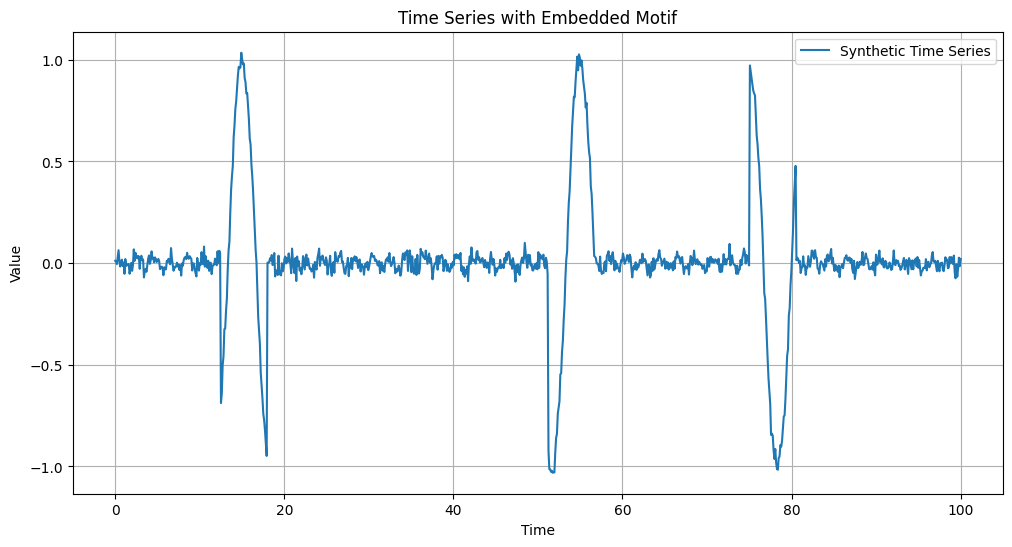

In [38]:
def generateSyntheticTimeSeries(numPts, time, baseAmp, baseFreq, motifAmp,motifFreq,motifLen,motifReps,noiseAmp):
    # generate a time range
    t = np.linspace(time[0], time[1], numPts)

    # generate the base time series
    baseSignal = baseAmp * np.sin(2 * np.pi * baseFreq * t)

    # select random locations on series to place motifs
    motif_start_indices = np.random.choice(numPts - motifLen, motifReps)

    # add the motifs into the base time series
    timeSeries = baseSignal.copy()
    for start_index in motif_start_indices:
        motif = motifAmp * np.sin(2 * np.pi * motifFreq * t[start_index:start_index + motifLen])
        timeSeries[start_index:start_index + motifLen] += motif

    # add random noise to obscure the motif
    timeSeries += noiseAmp * np.random.randn(numPts)
    # Plot the time series
    plt.figure(figsize=(12, 6))
    plt.plot(t, timeSeries, label="Synthetic Time Series")
    plt.title("Time Series with Embedded Motif")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()
    return t, timeSeries

#set parameters
num_points = 1000
time = [0,100]
base_amplitude = 0.025
base_frequency= 0.5
motif_amplitude=1.0
motif_frequency=0.15
motif_length=55
motif_repeats= 3
noise_amplitude = 0.025
t, time_series = generateSyntheticTimeSeries(num_points,time,base_amplitude,base_frequency,motif_amplitude,
                                             motif_frequency,motif_length,motif_repeats,noise_amplitude)



Matrix Profile

a) A matrix profile is a vector that holds the analysis of the time series data that reveals motifs, anomolies and other characteristics of the time series. To compute the matrix profile, 
1) you first decide on a length for the subsequences, m; a subsequence, Q, is defined as Qi = [T[i],T[i+1],...,T[i+m-1]] where T is the time series data 
2) Then you find the Euclidean distances between a subsequence and all the other subsequnces, this is distance profile: 
Di = sqrt(sigma,j=1->m(T[i+j-1]-Qi[j]^2))
3) Then you find the minimum in each distance profile where i !=j and the accumulation of these minimums is the matrix profile:
MP[i] = min,i!=j(Dj)
4) Along with matrix profile you also want to keep track of a matrix index profile which holds the index of a subsequences nearest neighbor:
I[i] = argmin,i!=j(Dj)



b)Matrix Profile Implementation

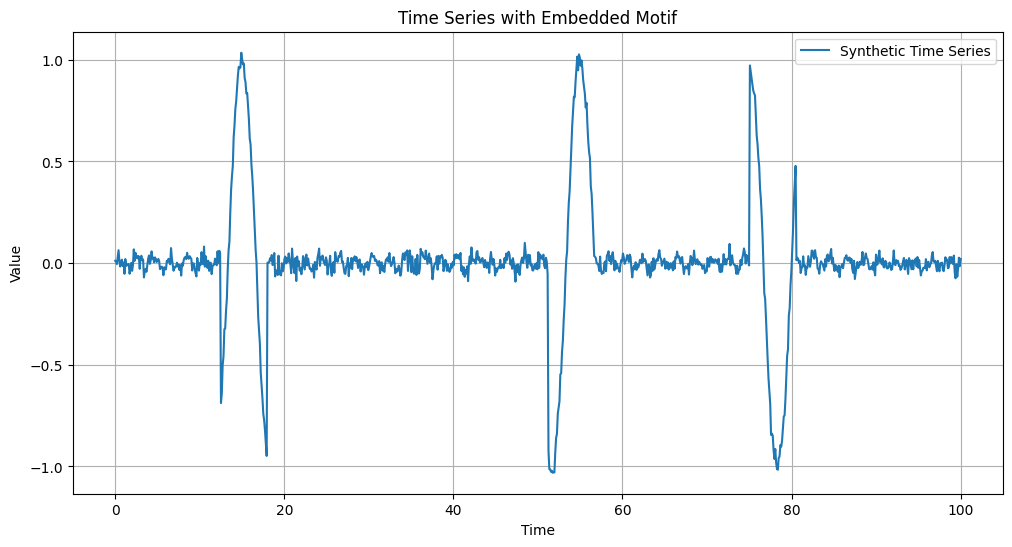

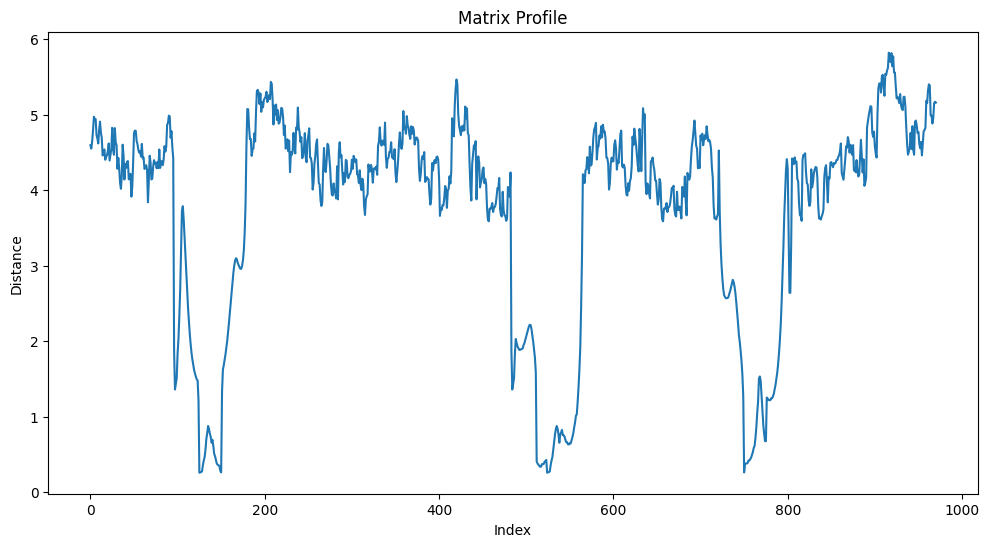

In [39]:
import numpy as np
#creates distance profile for each subsequence
#T is the time series and query is the subsequence that is finding its neighbors distances
def distanceProfile(T,query):
    n = len(T)
    m = len(query)
    # initialize an array to store the distances
    d = np.zeros(n)
    # normalize the query.
    Q = (query - np.mean(query)) / np.std(query)

    for i in range(n - m + 1):
        # Extract the subsequence from T.
        subsequence = T[i:i + m]
        # Normalize the subsequence.
        subsequence = (subsequence - np.mean(subsequence)) / np.std(subsequence)
        # Calculate the Euclidean distance between the normalized subsequence and the normalized query.
        d[i] = np.sqrt(np.sum((subsequence - Q) ** 2))
    return d
#finds all minimum of each distance profile and creates a matrix profile out of it along with crreating the index profile
#ts is the time series data and m is the size of subsequence window
def matrixProfile(ts, m):
    n = len(ts)
    #initializae matrix to hold the distance profiles
    matrix = np.zeros((n-m+1, n))
    #initialize matrix profile
    profile = []
    #initialize matrix index profile 
    profileIndex = []
    #perform distanceProfile function on each subsequence and save the disatnce profile to matrix
    for j in range(n-m+1):
        query = ts[j:j+m]
        dist = distanceProfile(ts,query)
        matrix[j, :] = dist
    # finds the nonzero minimum in each distance profile and index of its neighbor and appends accordingly to profile and profileIndex
    for row in matrix:
        non_zero_indices = np.nonzero(row)[0]
        if non_zero_indices.size > 0:
            min_index = non_zero_indices[np.argmin(row[non_zero_indices])]
            profileIndex.append(min_index)
            profile.append(row[min_index])
    #plots the matrix profile
    x = range(len(profile))
    plt.figure(figsize=(12, 6))
    plt.plot(x,profile)
    # Add labels and title
    plt.xlabel('Index')
    plt.ylabel('Distance')
    plt.title('Matrix Profile')
    # Show the plot
    plt.show()
    return profile,profileIndex


plt.figure(figsize=(12, 6))
plt.plot(t, time_series, label="Synthetic Time Series")
plt.title("Time Series with Embedded Motif")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()
window = 30
matrixprofile, profileindex = matrixProfile(time_series,window)




Uses a brute force sliding window approach to calculate the matrix profile and the profile index

Algorithm Implementation

a) Discovering motifs using sliding window approach

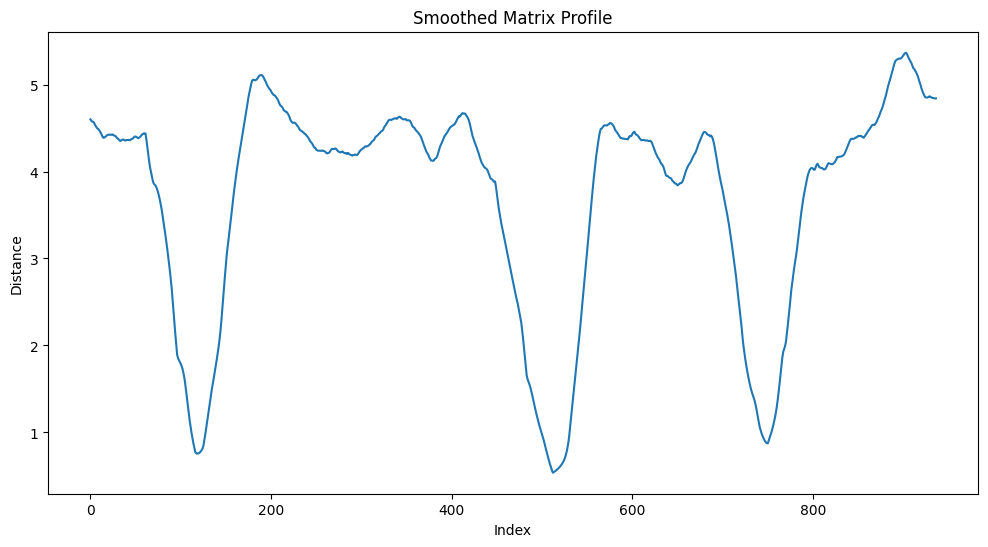

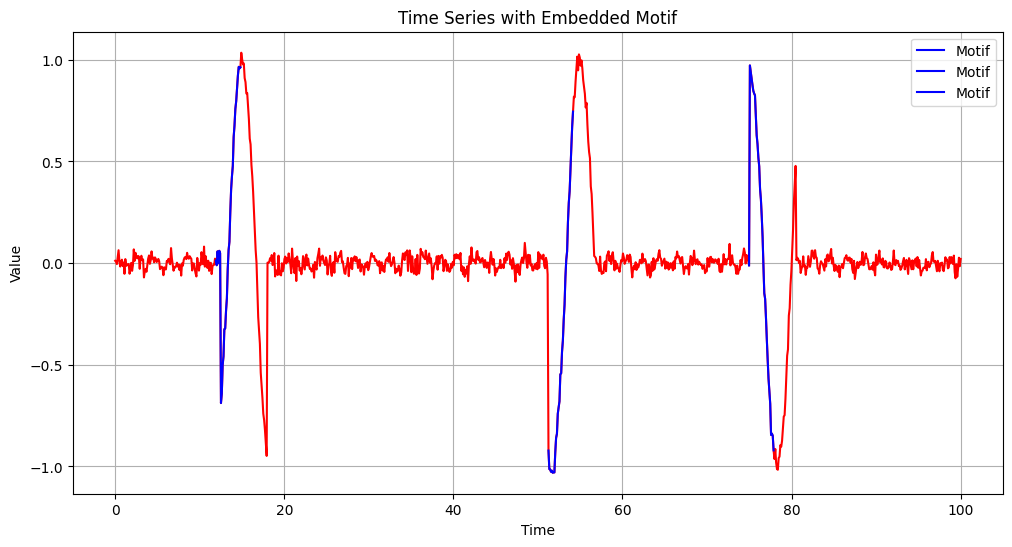

In [44]:
from scipy.signal import find_peaks
# function to smooth matrix profile data so peaks and valleys are more prominenent
def smoothData(smoothWindow,profile):
    #smooth matrix profile data
    smoothedData = np.convolve(profile, np.ones(smoothWindow) / smoothWindow, mode='valid')
    #plot smoothed matrix profile data
    x= range(len(smoothedData))
    plt.figure(figsize=(12, 6))
    plt.plot(x,smoothedData)
    plt.xlabel('Index')
    plt.ylabel('Distance')
    plt.title('Smoothed Matrix Profile')
    # Show the plot
    plt.show()
    return smoothedData

def detectMotifs(smoothedData, time ,series, numMotifs, windowLen):
    #invert the smoothedData so it finds the indicies of the minimums which are the motifs
    peak_idx, _= find_peaks(-smoothedData)
    #find the values/distances of the peaks 
    peak_heights = smoothedData[peak_idx]
    # create an array of the indicies of the heights in descending order
    descendingheightindicies = np.argsort(peak_heights)[-(len(peak_heights)):]
    # use the descending height indicies to arrange the indicies of the peaks in descenidng order
    descendingindicies = peak_idx[descendingheightindicies]
    #filter the descending indicies to find the most prominent peaks
    #intialize an array to hold the filtered indicies
    filtered_indices = []
    #filter descendingindicies to find peaks that are not within a 50 distance threshold with a previous index
    for index in descendingindicies:
        # Check if the current index is within the distance threshold of any previously selected index
        if not any(np.abs(index - selected_index) < 50 for selected_index in filtered_indices):
            filtered_indices.append(index)
    #using the number of motifs you want to find, select the top numMotifs
   
    motifIndicies = filtered_indices[0:numMotifs]
    #intialize a motifs array that holds the indicies of motifs
    motifs = []
    #for each motif, from its starting index increment to the size of the window to get the indices of the motif in the time series
    for motif in motifIndicies:
        motifs.append([motif+i for i in range(windowLen)])
    #plot the time series but with the motifs highlighted in blue
    plt.figure(figsize=(12, 6))
    # Plot the original data in red
    plt.plot(time, series, color='red')

    # Plot the selected portions in blue
    for motif in motifs:
        plt.plot(time[motif], series[motif], color='blue', label='Motif')

    plt.title("Time Series with Embedded Motif")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

smoothWindow = 35
thresPercent = 0.5
windowLen = 30
profile = matrixprofile
time = t
series = time_series
smoothedData = smoothData(smoothWindow, profile)
detectMotifs(smoothedData,time,series, 3, windowLen)


Once the matrix profile is made, we smooth it to find the prominent peaks and valleys. You input how many motifs you want to find. Essentially it inverts the matrix profile and finds the peaks, orders their indicies in descending order of their respective distances/values, and then choose the top n motifs where n is how many motifs the user wants to find. You may have to mess around with the smooth data window to find a cleaner matrix profile to work with.

b) Algorithm Optimization

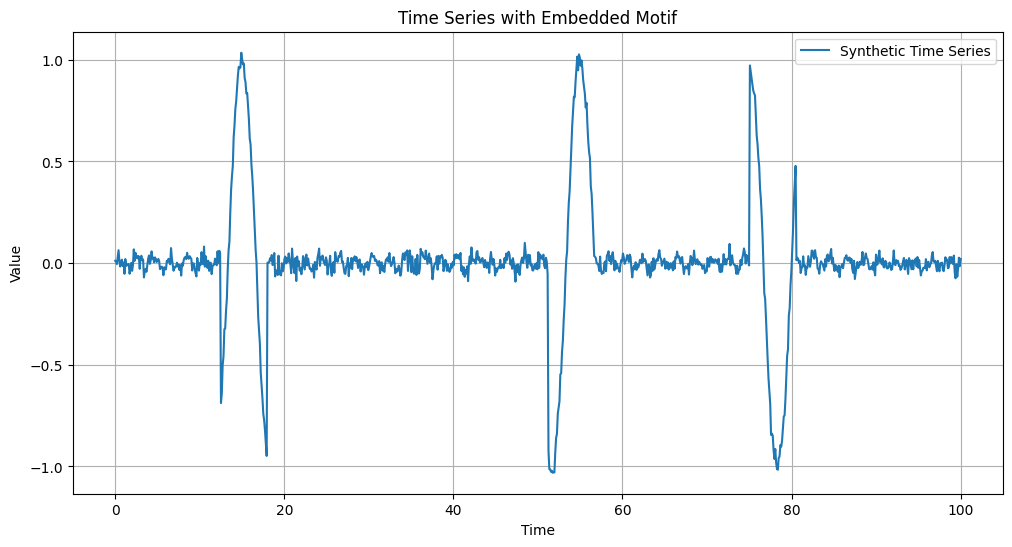

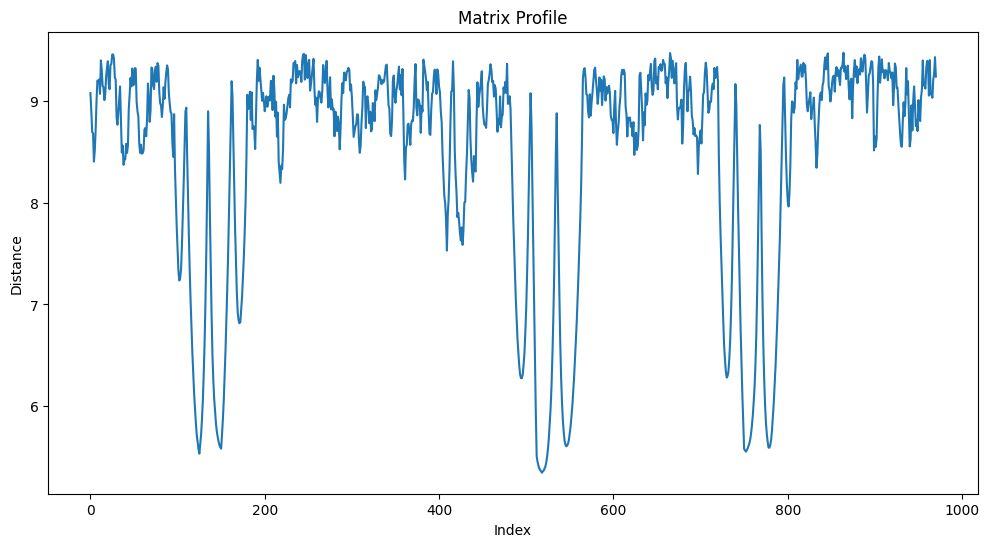

In [45]:
import numpy as np
import pandas as pd
from scipy.signal import fftconvolve

def optimizedDistanceProfile(T, query):
    n = len(T)  
    m = len(query)  

    # Normalize query using zNorm
    Q = (query - np.mean(query)) / np.std(query)

    #padding can be inefficient and cause problems if the length of the subsequnce is much shorter than the time series
    #so we perform convolution on the time series in blocks
    blockSize = int(len(Q)/2)
    
    #calculate the moving standard deviation for non-query time series
    Stdv= pd.Series(T).rolling(m).std(ddof=0).values[m-1:]
    #flip the query
    Q = np.flip(Q)
    #initialize a dots array
    dots = np.zeros(n+m-1)
    #perform convolution with the query and each block in the time series through fast fourier transform
    for i in range(0,n,blockSize):
        block_end = min(i+blockSize,n)
        blockT = T[i:block_end]
        blockResult = fftconvolve(blockT,Q,mode='full')
        dots[i:i +len(blockResult)] += blockResult
    #keep only valid part of results
    dots = dots[:n+m-1]
    #keep only real numbers
    dots = np.real(dots)
    #find the distance 
    dist = 2 * ((m - dots[m:n+1])/Stdv)
    dist = np.sqrt((abs(dist)))
    return dist
# same setup at matrix profile function from before(find the minimum of each distance profile and append to matrix profile)
#except all of it is done in one loop instead of two
def optimizedMatrixProfile(ts, m):
    n = len(ts)
    #initialize martix profile
    profile = []
    #initialize profileIndex
    profileIndex = []
    #loop through each subsequence and perform optimizedDistanceProfile on it, find the minimum distance(closest neighbor) and its index
    #append index and distance to appropriate matrix
    for j in range(n-m+1):
        query = ts[j:j+m]
        dist = optimizedDistanceProfile(ts,query)
        non_zero_indices = np.nonzero(dist)[0]
        min_index = non_zero_indices[np.argmin(dist[non_zero_indices])]
        profileIndex.append(min_index)
        profile.append(dist[min_index])
    #plot matrix profile
    x = range(len(profile))
    plt.figure(figsize=(12, 6))
    plt.plot(x,profile)
    plt.xlabel('Index')
    plt.ylabel('Distance')
    plt.title('Matrix Profile')
    # Show the plot
    plt.show()
    return profile,profileIndex



plt.figure(figsize=(12, 6))
plt.plot(t, time_series, label="Synthetic Time Series")
plt.title("Time Series with Embedded Motif")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()
optimizedmatrixprofile, optimizedprofileindex = optimizedMatrixProfile(time_series,window)



This optimized approach uses fast fourier transform to find the distance profiles for each query. On the brute force function, a 1000 element time series took roughly 1 minute to develop the matrix profile. The optimized version took less than 10 seconds.

c) Testing on various synthetic timeseries

Synthetic Timeseries 1

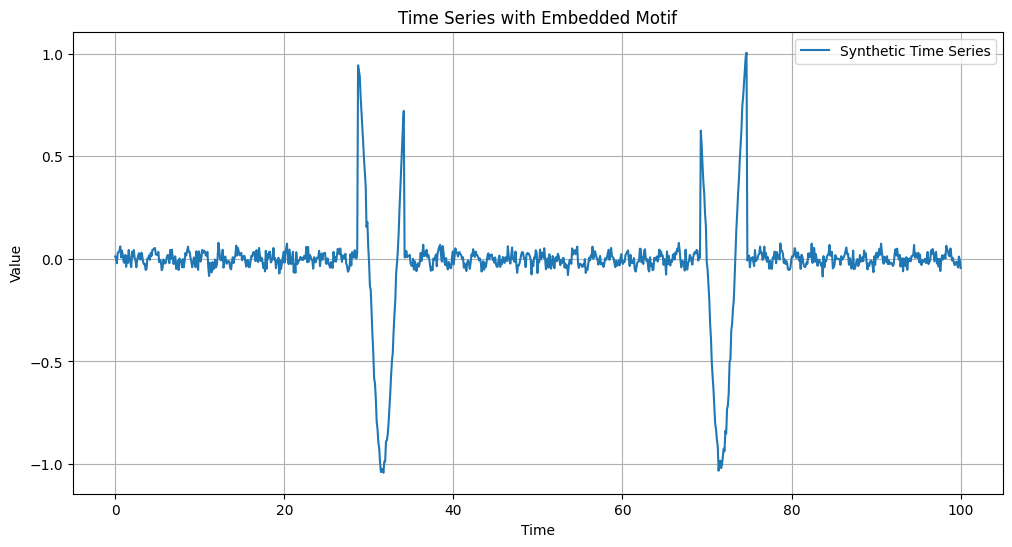

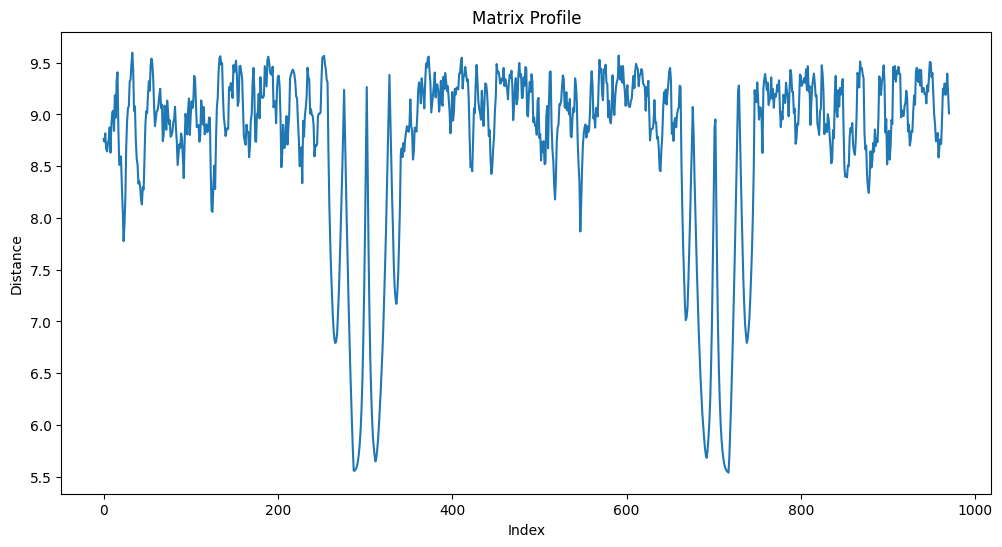

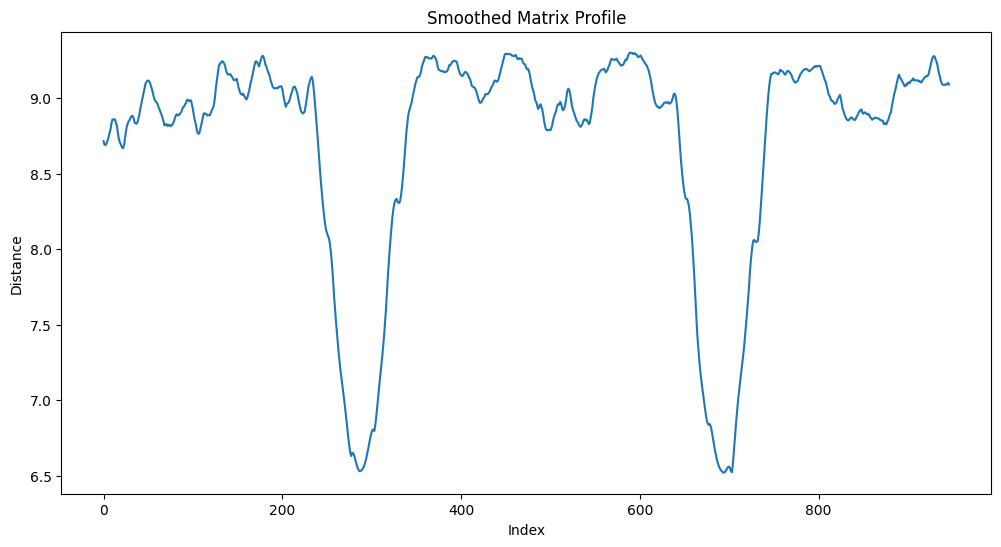

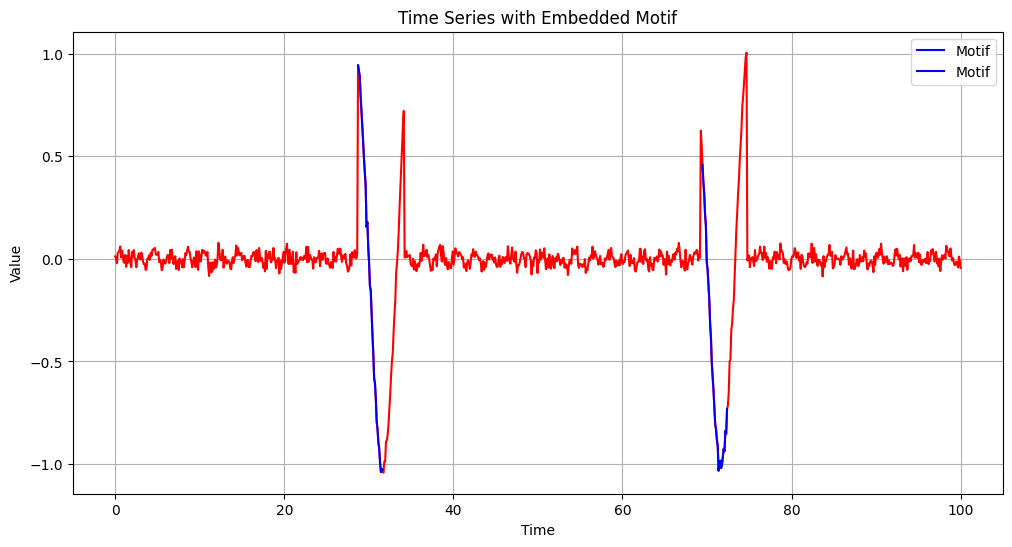

In [15]:
num_points = 1000
time = [0,100]
base_amplitude = 0.025
base_frequency= 0.5
motif_amplitude=1.0
motif_frequency=0.15
motif_length=55
motif_repeats= 2
noise_amplitude = 0.025
t1, series1 = generateSyntheticTimeSeries(num_points,time,base_amplitude,base_frequency,motif_amplitude,
                                             motif_frequency,motif_length,motif_repeats,noise_amplitude)
slidingWindow1 = 30
profile1, _ = optimizedMatrixProfile(series1, slidingWindow1)
smoothWindow1 = 25
smoothedData1 = smoothData(smoothWindow1,profile1)
numMotifs =2 
detectMotifs(smoothedData1,t1,series1, numMotifs, slidingWindow1)


Synthetic Timeseries 2

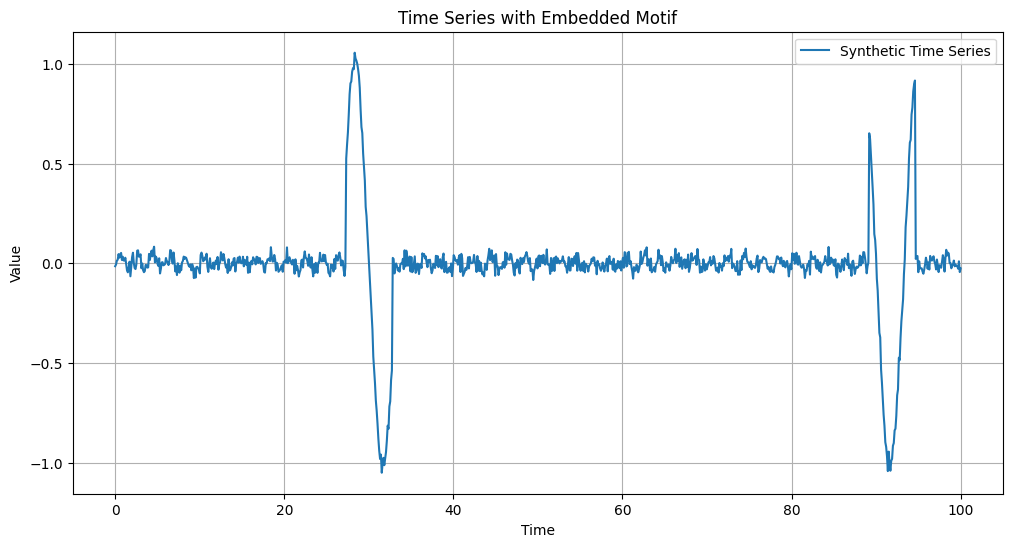

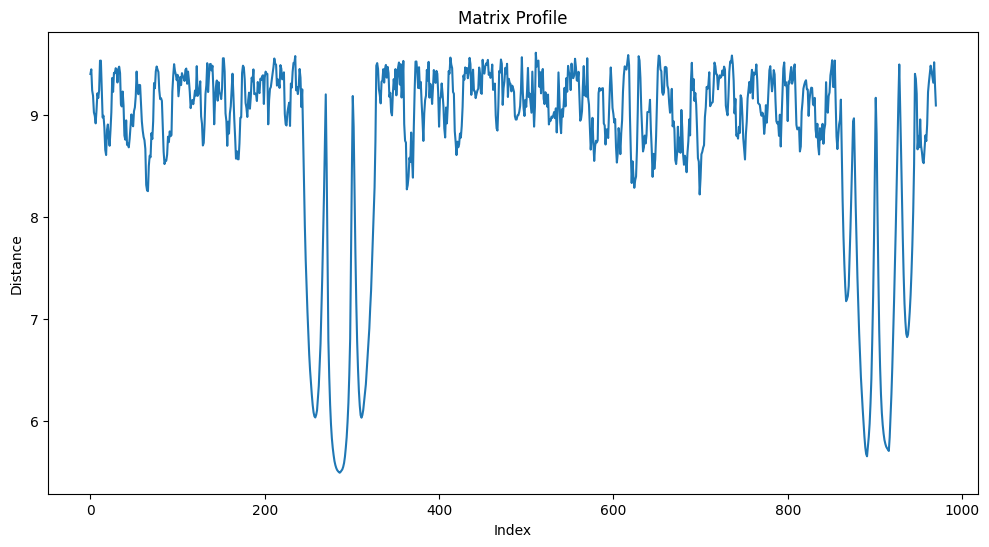

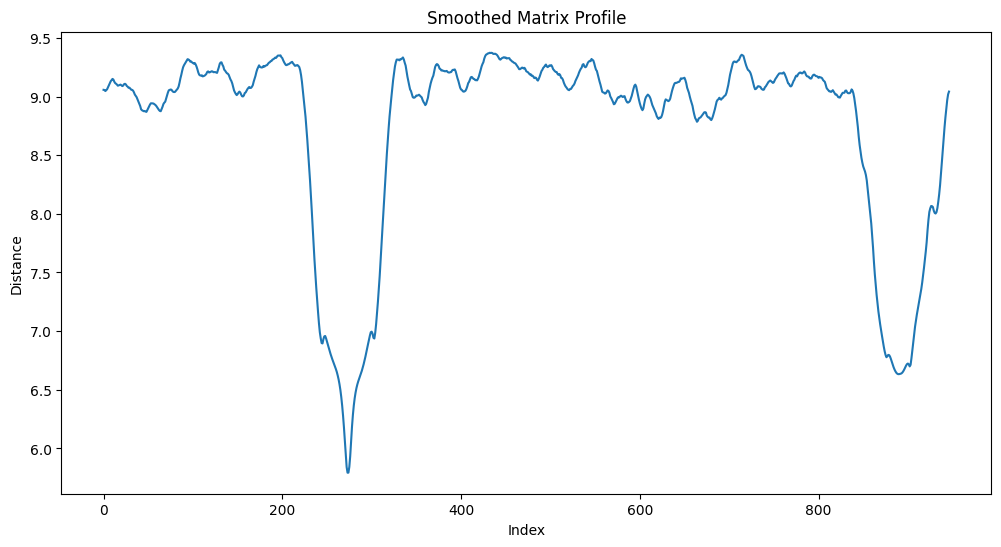

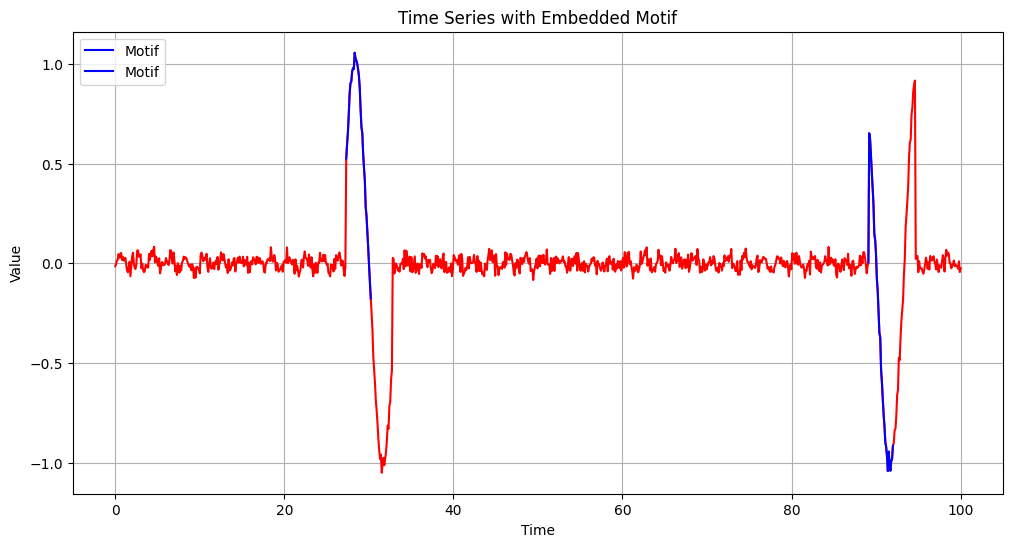

In [16]:
num_points = 1000
time = [0,100]
base_amplitude = 0.025
base_frequency= 0.5
motif_amplitude=1.0
motif_frequency=0.15
motif_length=55
motif_repeats= 2
noise_amplitude = 0.025
t2, series2 = generateSyntheticTimeSeries(num_points,time,base_amplitude,base_frequency,motif_amplitude,
                                             motif_frequency,motif_length,motif_repeats,noise_amplitude)
slidingWindow2 = 30
profile2, _ = optimizedMatrixProfile(series2, slidingWindow2)
smoothWindow2 = 25
smoothedData2 = smoothData(smoothWindow2,profile2)
numMotifs =2 
detectMotifs(smoothedData2,t2,series2, numMotifs, slidingWindow2)


Synthetics Timeseries 3

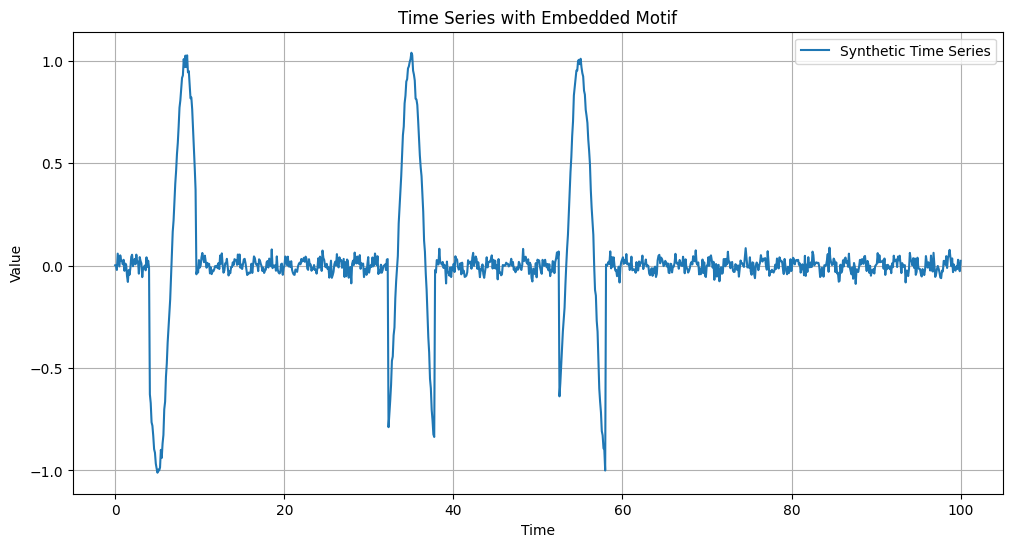

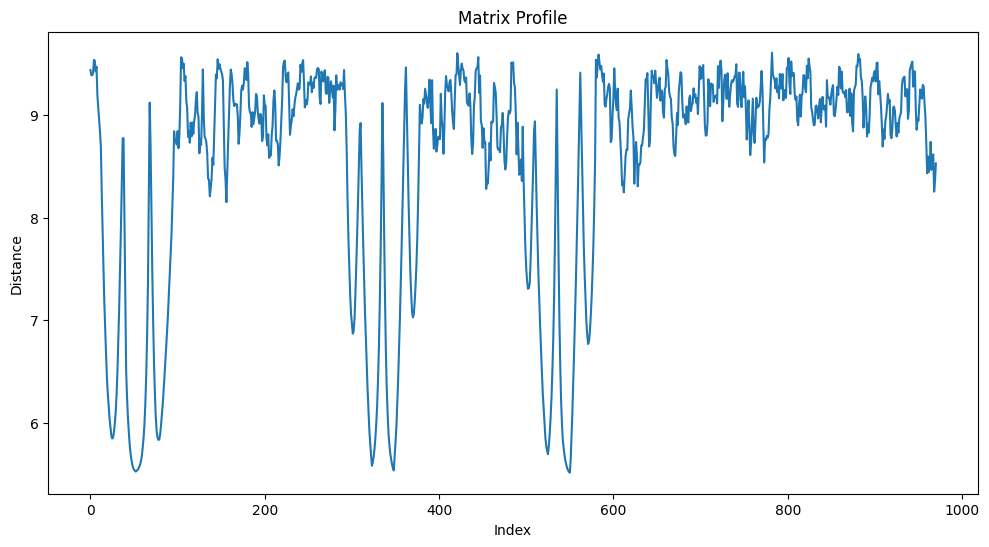

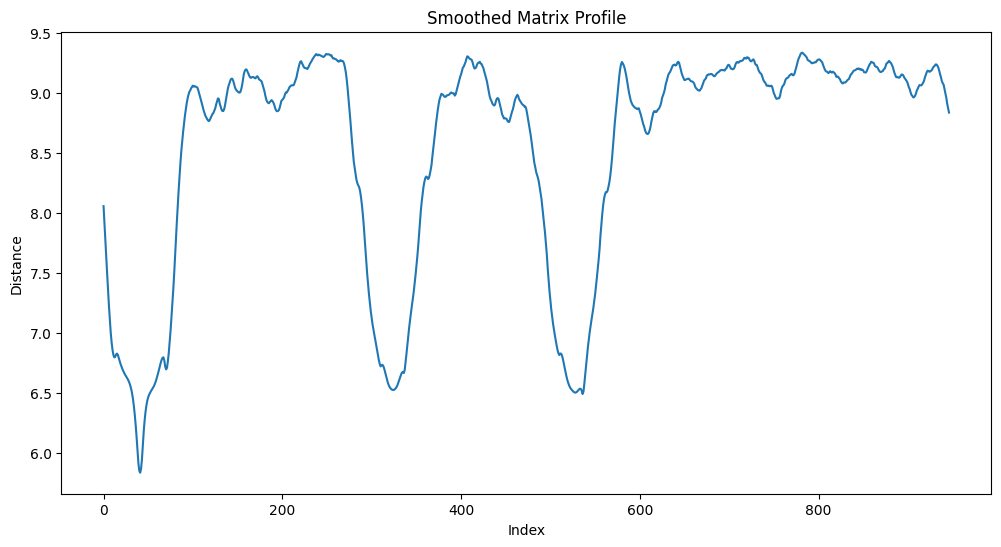

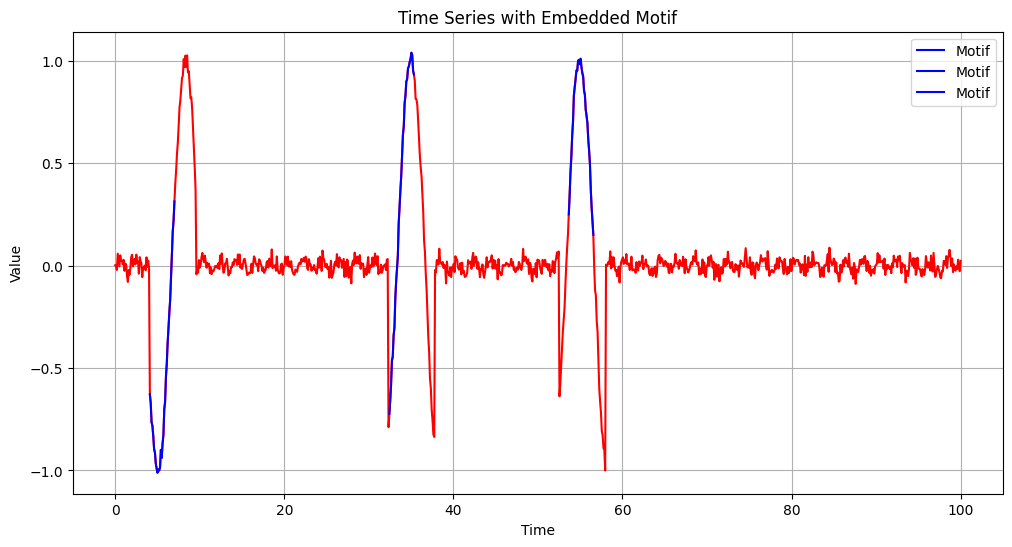

In [21]:
num_points = 1000
time = [0,100]
base_amplitude = 0.025
base_frequency= 0.5
motif_amplitude=1.0
motif_frequency=0.15
motif_length=55
motif_repeats= 3
noise_amplitude = 0.025
t3, series3 = generateSyntheticTimeSeries(num_points,time,base_amplitude,base_frequency,motif_amplitude,
                                             motif_frequency,motif_length,motif_repeats,noise_amplitude)
slidingWindow3 = 30
profile3, _ = optimizedMatrixProfile(series3, slidingWindow3)
smoothWindow3 = 25
smoothedData3 = smoothData(smoothWindow3,profile3)
numMotifs =3 
detectMotifs(smoothedData3,t3,series3, numMotifs, slidingWindow3)

Discord Identification

a) a discord is a subsequence in a time series or a particular time series in a database of timeseries that is more unsimilar than average. In terms of the matrix profile the highest value is the anomoly as it means that its closest neighbor is more disimalar than the average subsequences neighbor
Mathematically discords are defined as: 
Of a time series database D, the unordered pair of time series{Ti, Tj} which is the least similar among all possible pairs
For all a,b,i,j there exists {Ti,Tj} where dist(Ti,Tj) >=dist(Ta,Tb), i !=j and a!=b
Similarly a subsequence time series motif is defined as: 
Of a long time series T, a pair of subsequences {Tin, Tjn} that are the most similar compared to all other pairs. 
For all a,b,i,j there exists {Tin,Tjn} where dist(Tin, Tjn) <= dist(Tan,Tbn)

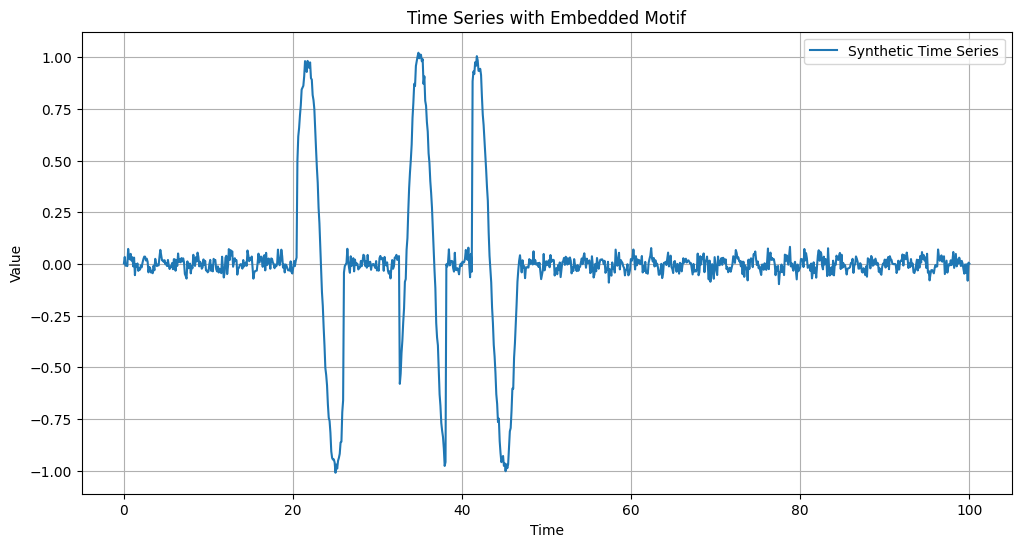

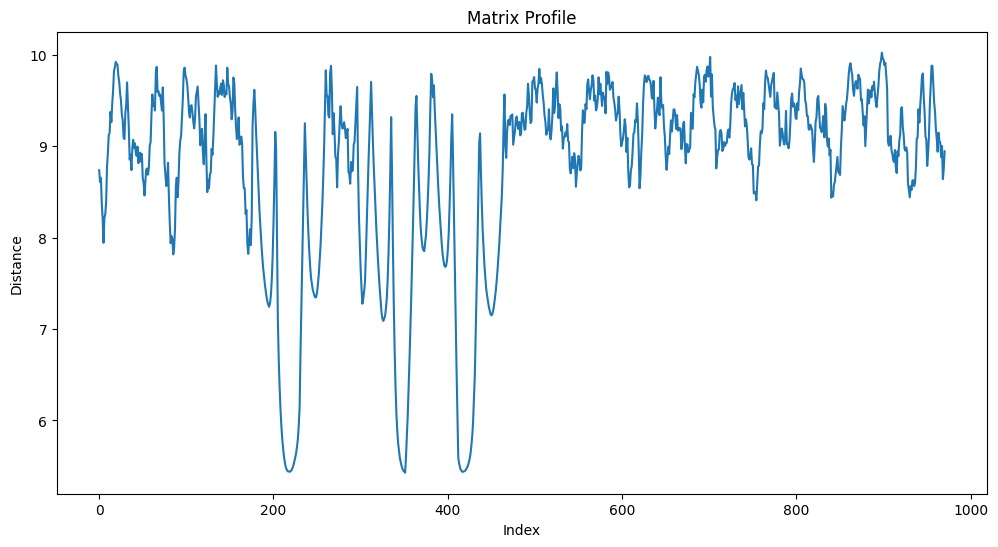

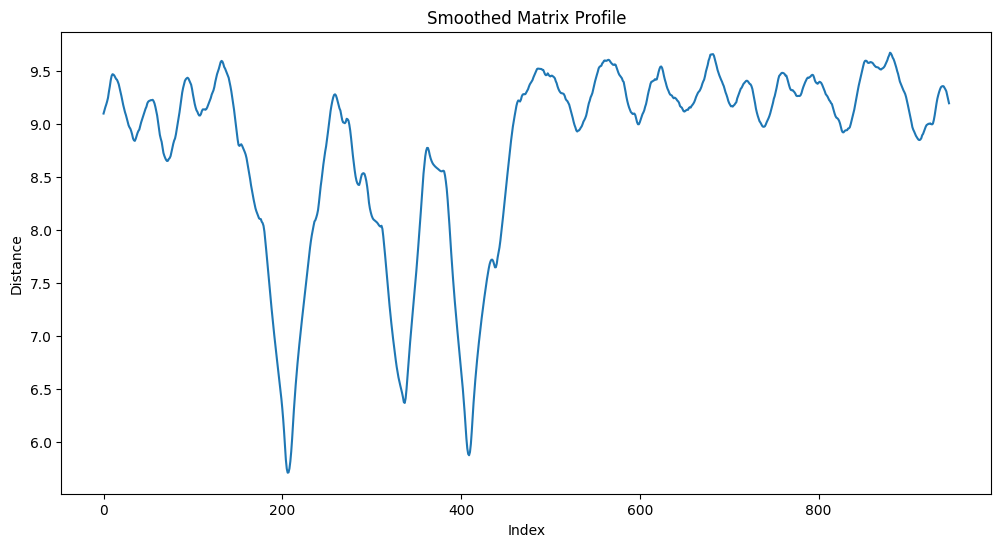

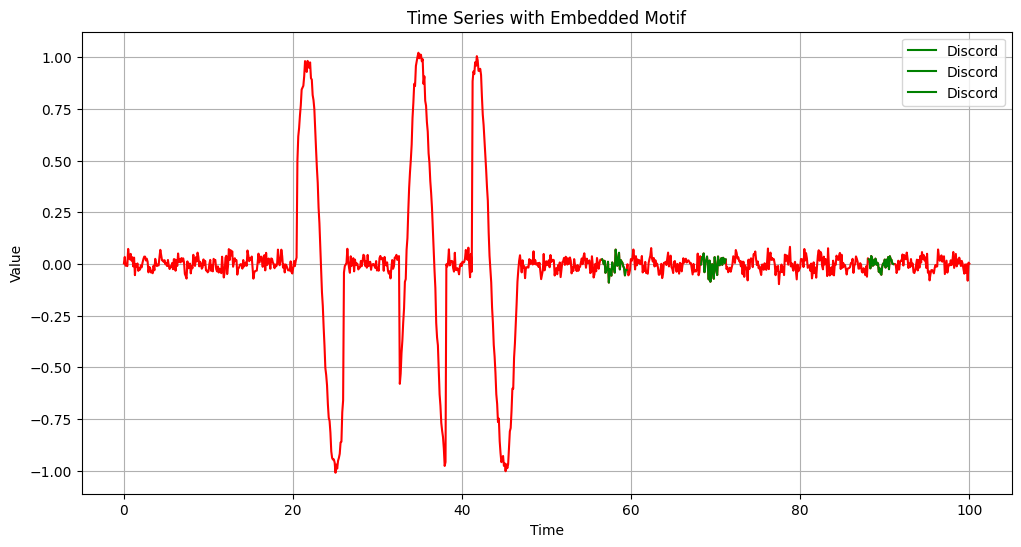

In [55]:
#same function as motif detection except you do not inverte the smoothed data to find the indicies of the peaks as the peaks in 
#the normal smoothed data are the discords, but you inverte the smoothedData when finiding the distances at these peaks
def discordDetection(smoothedData, time ,series, numDiscords, windowLen):
    #find the indicies of the peaks
    peak_idx, _= find_peaks(smoothedData)
    #find the values/distances of the peaks 
    peak_heights = -smoothedData[peak_idx]
    # create an array of the indicies of the heights in descending order
    descendingheightindicies = np.argsort(peak_heights)[-(len(peak_heights)):]
    # use the descending height indicies to arrange the indicies of the peaks in descenidng order
    descendingindicies = peak_idx[descendingheightindicies]

    #filter the descending indicies to find the most prominent peaks
    #intialize an array to hold the filtered indicies
    filtered_indices = []
    #filter descendingindicies to find peaks that are not within a 50 distance threshold with a previous index
    for index in descendingindicies:
        # Check if the current index is within the distance threshold of any previously selected index
        if not any(np.abs(index - selected_index) < 50 for selected_index in filtered_indices):
            filtered_indices.append(index)
    #using the number of discords you want to find, select the top numDiscords
   
    discordIndicies = filtered_indices[0:numDiscords]
    #intialize a discords array that holds the indicies of discords
    discords = []
    #for each discord, from its starting index increment to the size of the window to get the indices of the discord in the time series
    for discord in discordIndicies:
        discords.append([discord+i for i in range(windowLen)])
    #plot the time series but with the discords highlighted in blue
    plt.figure(figsize=(12, 6))
    # Plot the original data in red
    plt.plot(time, series, color='red')

    # Plot the selected portions in green
    for discord in discords:
        plt.plot(time[discord], series[discord], color='green', label='Discord')

    plt.title("Time Series with Embedded Motif")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()
#test on synthetic time series
num_points = 1000
time = [0,100]
base_amplitude = 0.025
base_frequency= 0.5
motif_amplitude=1.0
motif_frequency=0.15
motif_length=55
motif_repeats= 3
noise_amplitude = 0.025
t4, series4 = generateSyntheticTimeSeries(num_points,time,base_amplitude,base_frequency,motif_amplitude,
                                             motif_frequency,motif_length,motif_repeats,noise_amplitude)
slidingWindow4 = 30
profile4, _ = optimizedMatrixProfile(series4, slidingWindow4)
smoothWindow4 = 25
smoothedData4 = smoothData(smoothWindow4,profile4)
numDiscords =3
discordDetection(smoothedData4,t4,series4, numDiscords, slidingWindow4)

    

Real world dataset example: Average temperautre per day in New Delhi from January 1st 2013 to January 1st 2017

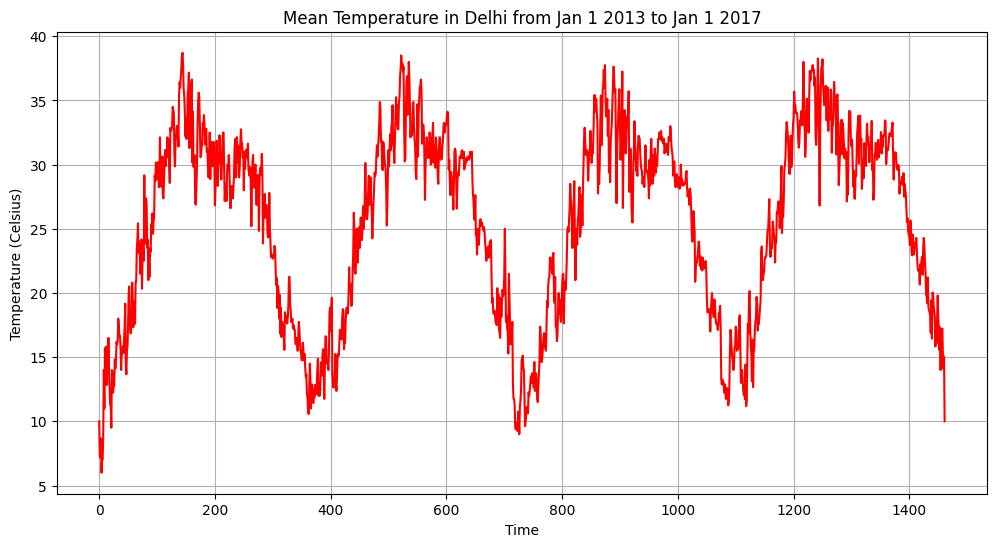

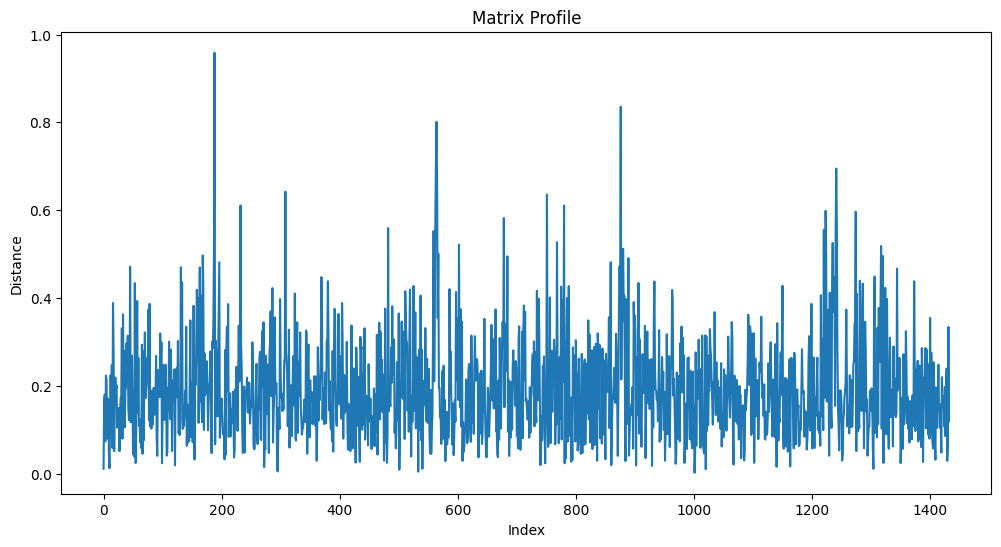

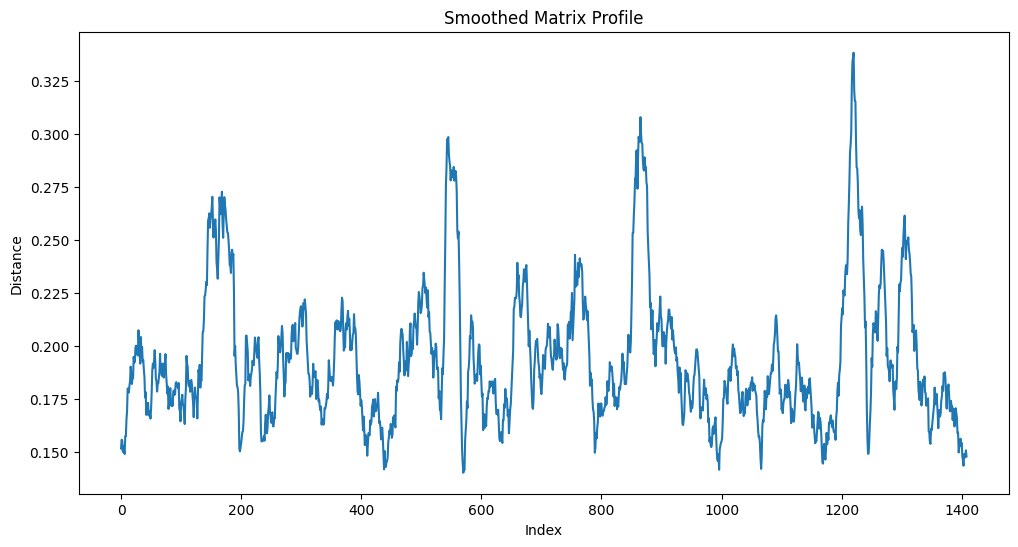

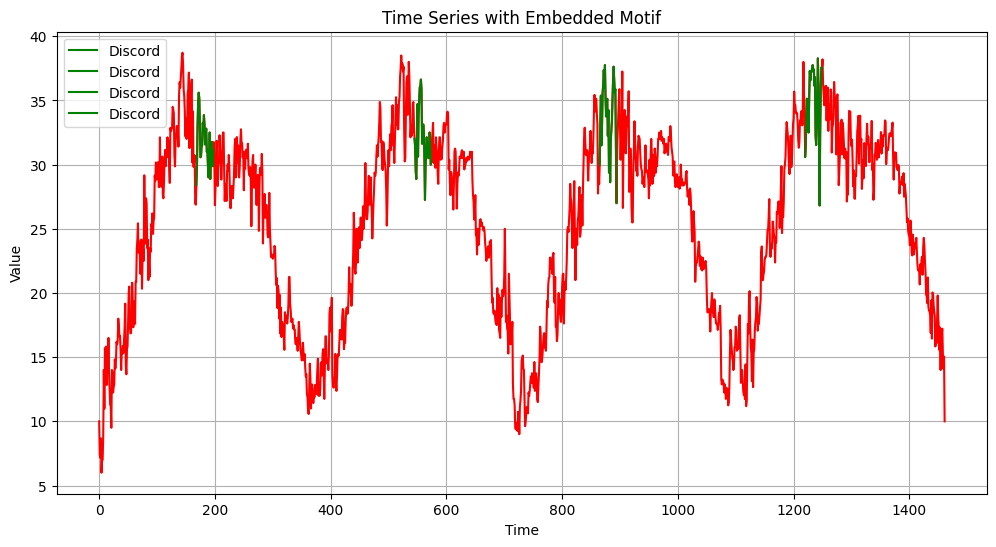

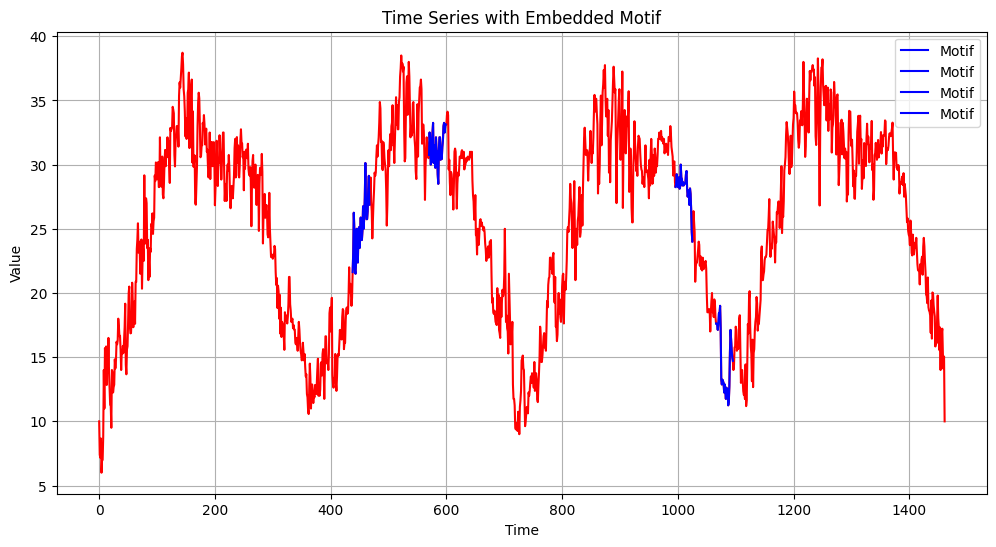

In [64]:
import pandas as pd

# Replace 'your_file.csv' with the actual path to your CSV file
file_path = 'DailyDelhiClimateTrain.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

# Extract the data for the 'meantemp' column
meantemp_data = df['meantemp']
series5 = meantemp_data.values

t5 = np.array([0+i for i in range (len(series5))])
plt.figure(figsize=(12,6))
plt.plot(t5,series5,color='red')
plt.title("Mean Temperature in Delhi from Jan 1 2013 to Jan 1 2017")
plt.xlabel("Time")
plt.ylabel("Temperature (Celsius)")
plt.grid(True)
plt.show()
slidingWindow5 = 30
profile5, _ = optimizedMatrixProfile(series5, slidingWindow5)
smoothWindow5 = 25
smoothedData5 = smoothData(smoothWindow5,profile5)
num_Discords = 4
num_Motifs = 4
discordDetection(smoothedData5,t5,series5,num_Discords,slidingWindow5)
detectMotifs(smoothedData5,t5,series5,num_Motifs,slidingWindow5)

Neural Networks

1. DNN Implementation

In [3]:
import numpy as np
class SimpleNN:
    def __init__(self, input_dim, hidden_dim, output_dim):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.W1, self.b1, self.W2, self.b2 = self.initialize_parameters()
    def initialize_parameters(self):
        #Initialize weights and biases
        W1 = np.random.randn(self.hidden_dim, self.input_dim) * 0.01
        b1 = np.zeros((self.hidden_dim, 1))
        W2 = np.random.randn(self.output_dim, self.hidden_dim) * 0.01
        b2 = np.zeros((self.output_dim, 1))
        return W1,b1,W2,b2
    def sigmoid(self,Z):
        #Sigmoid activation function
        result = 1/(1+np.exp(-Z))
        return result
    def foward_propagation(self,X):
        #Forward propagation
        Z1 = np.dot(self.W1,X)+self.b1
        A1 = self.sigmoid(Z1)
        Z2 = np.dot(self.W2,A1)+self.b2
        A2 = self.sigmoid(Z2)
        return Z1,A1,Z2,A2
    def compute_cost(self, A2, Y):
        m = Y.shape[1]
        print(m)
        #probs = (np.multiply(np.log(A2+1e-10),Y)+np.multiply(np.log(1-A2+1e-10),(1-Y)))
        #cost = (-1/m)*np.sum(probs)
        cost = (-1/m)* np.sum(Y * np. log (A2) + (1 - Y) * np. log (1 - A2))
        return cost
    def backpropagation(self,X,Y,Z1,A1,Z2,A2):
        grads = {}
        m = X.shape[1]

        #Compute gradients
        dZ2 =A2 -Y
        dW2 = np.dot(dZ2,A1.T)/m
        db2 = np.sum(dZ2, axis=1, keepdims =True)/m
        dZ1 = np.dot(self.W2.T, dZ2)*(A1*(1-A1))
        dW1 = np.dot(dZ1,X.T)/m
        db1 = np.sum(dZ1, axis=1,keepdims=True)/m

        grads['dW1']= dW1
        grads['db1']=db1
        grads['dW2'] = dW2
        grads['db2']=db2
        return grads
    def update_parameters(self,grads,learning_rate):
        #Update weights and biases
        self.W1 -= learning_rate*grads['dW1']
        self.b1 -= learning_rate*grads['db1']
        self.W2 -= learning_rate*grads['dW2']
        self.b2 -= learning_rate*grads['db2']
    def train(self, X,Y,learning_rate,num_iterations):
        for i in range(num_iterations):
            Z1,A1,Z2,A2 = self.foward_propagation(X)
            cost = self.compute_cost(Y,A2)
            grads = self.backpropagation(X,Y,Z1,A1,Z2,A2)
            self.update_parameters(grads,learning_rate)
            if i % 100 ==0:
                print(f"Iterattion{i}, Cost: {cost}")
if __name__== "__main__":
    #Generate synthetic data
    X = np.random.rand(2,500)
    Y = np.random.randint(0,2,size=(1,500))
    #Initializa neural network
    nn = SimpleNN(2,4,1)
    #Train the neural network
    nn.train(X,Y,learning_rate=0.01,num_iterations=1000)

/var/folders/b_/ybg5r8x93hj0c9sh9z04nrzh0000gn/T/ipykernel_57959/3339916589.py:30: RuntimeWarning: divide by zero encountered in log
  cost = (-1/m)* np.sum(Y * np. log (A2) + (1 - Y) * np. log (1 - A2))


Iterattion0, Cost: inf
Iterattion100, Cost: inf
Iterattion200, Cost: inf
Iterattion300, Cost: inf
Iterattion400, Cost: inf
Iterattion500, Cost: inf
Iterattion600, Cost: inf
Iterattion700, Cost: inf
Iterattion800, Cost: inf
Iterattion900, Cost: inf


As we can see the cost decreases in every iteration meaning the weights and biases are being more correctly tuned to learn the data

2. CNN Implementation

In [33]:
import numpy as np
def convolution2D(image,kernel):
    #Get the dimensions of the image and the kernel
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape

    #Calculate the output dimensions
    output_height = image_height -kernel_height+1
    output_width = image_width - kernel_width+1

    #Initialize the output feature map
    output = np.zeros((output_height,output_width))

    #Perform 2D convolution
    for i in range(output_height):
        for j in range(output_width):
            #Extract the regin of interest
            ROI = image[i:i+kernel_height, j:j+kernel_width]
            #Compute element-wise multiplication and sum
            sum =0
            for r in range(len(ROI)):
                for k in range(len(ROI[r])):
                    product = ROI[r,k]*kernel[r,k]
                    sum = sum+product
            output[i,j]=sum
    return output
#Example usage:
if __name__ == "__main__":
    #Create a sample grayscale image(8x8 pixels)
    image = np.array([[1,2,3,4,5,6,7,8],
                      [8,7,6,5,4,3,2,1],
                      [1,2,3,4,5,6,7,8],
                      [8,7,6,5,4,3,2,1],
                      [1,2,3,4,5,6,7,8],
                      [8,7,6,5,4,3,2,1],
                      [1,2,3,4,5,6,7,8],
                      [8,7,6,5,4,3,2,1]])
    #Create sample kernel(3x3)
    kernel = np.array([[1,0,-1],[1,0,-1],[1,0,-1]])
    #Perform 2D convolution
    result = convolution2D(image,kernel)
    print(result)



[[-2. -2. -2. -2. -2. -2.]
 [ 2.  2.  2.  2.  2.  2.]
 [-2. -2. -2. -2. -2. -2.]
 [ 2.  2.  2.  2.  2.  2.]
 [-2. -2. -2. -2. -2. -2.]
 [ 2.  2.  2.  2.  2.  2.]]
